In [1]:
%load_ext watermark
%watermark -a 'cs224' -u -d -v -p numpy,xarray,scipy,pandas,sklearn,matplotlib,seaborn,pymc3

cs224 
last updated: 2020-04-16 

CPython 3.6.10
IPython 7.13.0

numpy 1.18.1
xarray 0.15.0
scipy 1.4.1
pandas 1.0.2
sklearn 0.22.1
matplotlib 3.1.3
seaborn 0.10.0
pymc3 3.8


In [2]:
%matplotlib inline
import numpy as np, scipy, scipy.stats as stats, scipy.special, scipy.misc, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, xarray as xr
import matplotlib as mpl

import pymc3 as pm

import theano as thno
import theano.tensor as T

import sklearn, sklearn.linear_model

import datetime, time, math
from dateutil import relativedelta

from collections import OrderedDict

SEED = 42
np.random.seed(SEED)

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
# pd.set_option('display.float_format', lambda x: '%.2f' % x)
np.set_printoptions(edgeitems=10)
np.set_printoptions(linewidth=1000)
np.set_printoptions(suppress=True)
np.core.arrayprint._line_width = 180

sns.set()
# sns.set_style("whitegrid")

In [3]:
from IPython.display import display, HTML

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        if type(df) == np.ndarray:
            df = pd.DataFrame(df)
        html_str+=df.to_html()
    html_str = html_str.replace('table','table style="display:inline"')
    # print(html_str)
    display_html(html_str,raw=True)

CSS = """
.output {
    flex-direction: row;
}
"""

def display_graphs_side_by_side(*args):
    html_str='<table><tr>'
    for g in args:
        html_str += '<td>'
        html_str += g._repr_svg_()
        html_str += '</td>'
    html_str += '</tr></table>'
    display_html(html_str,raw=True)
    

display(HTML("<style>.container { width:70% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 1
%aimport covid19

* [Corona-Hub von www.npgeo.de](https://npgeo-corona-npgeo-de.hub.arcgis.com/)
    * [RKI COVID19](https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0)
    * [CSV](https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv)
    * [Robert Koch-Institut: COVID-19-Dashboard](https://npgeo-corona-npgeo-de.hub.arcgis.com/app/478220a4c454480e823b17327b2bf1d4)
* [Priesemann-Group/covid19_inference_forecast](https://github.com/Priesemann-Group/covid19_inference_forecast/commit/4d34d342cd8e58c18b5107ce38c537d4e83bc561)
    * [data_retrieval.py](https://github.com/Priesemann-Group/covid19_inference_forecast/blob/master/covid19_inference/data_retrieval.py)

In [5]:
# import json
# import urllib.request
# import yaml

In [6]:
# https://npgeo-corona-npgeo-de.hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0
# 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?outFields=*&where=1%3D1'
# 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?where=1%3D1&objectIds=&time=&resultType=none&outFields=*&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='

# 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?where=1%3D1&objectIds=&time=&resultType=none&outFields=           &returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='
# 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/ArcGIS/rest/services/RKI_COVID19/FeatureServer/0/query?where=0%3D0&objectIds=&time=&resultType=none&outFields=idLandkreis&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=true&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='
# 
# 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?where=1%3D1                           &objectIds=&time=&resultType=none&outFields=                                                                                                                                                &returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='
# 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/ArcGIS/rest/services/RKI_COVID19/FeatureServer/0/query?where=IdLandkreis%3D'+ idlandkreis + '&objectIds=&time=&resultType=none&outFields=Bundesland%2C+Landkreis%2C+Altersgruppe%2C+Geschlecht%2C+AnzahlFall%2C+AnzahlTodesfall%2C+Meldedatum%2C+NeuerFall%2C+NeuGenesen%2C+AnzahlGenesen&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='

In [7]:
# url_id = 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/ArcGIS/rest/services/RKI_COVID19/FeatureServer/0/query?where=0%3D0&objectIds=&time=&resultType=none&outFields=idLandkreis&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=true&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='
# url = urllib.request.urlopen(url_id)
# json_data = json.loads(url.read().decode())
# n_data = len(json_data['features'])
# unique_ids = [json_data['features'][i]['attributes']['IdLandkreis'] for i in range(n_data)]

In [8]:
# n_data

In [9]:
# unique_ids

In [10]:
# print(yaml.dump(json_data))

In [11]:
# if n_data == 412:

In [12]:
# print('Downloading {:d} unique Landkreise'.format(n_data))

In [13]:

# df_keys = ['Bundesland', 'Landkreis', 'Altersgruppe', 'Geschlecht', 'AnzahlFall',
#    'AnzahlTodesfall', 'Meldedatum', 'NeuerFall']

# df = pd.DataFrame(columns=df_keys)

# #Fills DF with data from all landkreise
# for idlandkreis in unique_ids:
#     url_str = 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/ArcGIS/rest/services/RKI_COVID19/FeatureServer/0/query?where=IdLandkreis%3D%27'+ idlandkreis + '%27&objectIds=&time=&resultType=none&outFields=Bundesland%2C+Landkreis%2C+Altersgruppe%2C+Geschlecht%2C+AnzahlFall%2C+AnzahlTodesfall%2C+Meldedatum%2C+NeuerFall&returnIdsOnly=false&returnUniqueIdsOnly=false&returnCountOnly=false&returnDistinctValues=false&cacheHint=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&having=&resultOffset=&resultRecordCount=&sqlFormat=none&f=pjson&token='

#     with urllib.request.urlopen(url_str) as url:
#         json_data = json.loads(url.read().decode())

#     n_data = len(json_data['features'])

#     if n_data > 5000:
#         ValueError('Query limit exceeded')

#     data_flat = [json_data['features'][i]['attributes'] for i in range(n_data)]

#     df_temp = pd.DataFrame(data_flat)

#     #Very inneficient, but it will do
#     df = pd.concat([df, df_temp], ignore_index=True)

# df['date'] = df['Meldedatum'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e3))   


In [14]:
# df

* [data source description](https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74)

In [15]:
#                  https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv
# df_ = pd.read_csv('https://opendata.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6_0.csv')
# https://www.arcgis.com/home/item.html?id=f10774f1c63e40168479a1feb6c7ca74
# https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data
# df_   = pd.read_csv('./RKI_COVID19.csv')
df_   = pd.read_csv('https://www.arcgis.com/sharing/rest/content/items/f10774f1c63e40168479a1feb6c7ca74/data')

In [16]:
df_.head()

,IdBundesland,Bundesland,Landkreis,Altersgruppe,Geschlecht,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,Landkreis ID,Datenstand,Neuer Fall,Neuer Todesfall,Referenzdatum,Neu Genesen,Anzahl Genesen
0,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2408401,3/14/2020 12:00:00 AM,1001,"16.04.2020, 00:00 Uhr",0,-9,3/16/2020 12:00:00 AM,0,1
1,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2408402,3/19/2020 12:00:00 AM,1001,"16.04.2020, 00:00 Uhr",0,-9,3/13/2020 12:00:00 AM,0,1
2,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2408403,3/19/2020 12:00:00 AM,1001,"16.04.2020, 00:00 Uhr",0,-9,3/16/2020 12:00:00 AM,0,1
3,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2408404,3/21/2020 12:00:00 AM,1001,"16.04.2020, 00:00 Uhr",0,-9,3/13/2020 12:00:00 AM,0,1
4,1,Schleswig-Holstein,SK Flensburg,A15-A34,M,1,0,2408405,3/27/2020 12:00:00 AM,1001,"16.04.2020, 00:00 Uhr",0,-9,3/22/2020 12:00:00 AM,0,1


In [17]:
df_['AnzahlFall'].sum()

130382

In [18]:
# 2020-04-15 RKI: 127508 RKI-Dashboard: 127,584 n-tv für Ende 2020-04-14: 128474

In [19]:
# df.to_excel("rki_covid19_data.xlsx") 

In [20]:
lds = df_['Bundesland']
lds.unique()

array(['Schleswig-Holstein', 'Hamburg', 'Niedersachsen', 'Bremen', 'Nordrhein-Westfalen', 'Hessen', 'Rheinland-Pfalz', 'Baden-Württemberg', 'Bayern', 'Saarland', 'Berlin', 'Brandenburg', 'Mecklenburg-Vorpommern', 'Sachsen', 'Sachsen-Anhalt', 'Thüringen'], dtype=object)

In [21]:
# df = covid19.get_rki()
# df.head()

In [38]:
def timeline(in_df, state=None, county=None, time_anchor_column_name='Referenzdatum', count_column_name='AnzahlFall'):
    ldf = in_df.copy()
    if state is not None:
        ldf = ldf[ldf['Bundesland'] == state].copy()
    if county is not None:
        ldf = ldf[ldf['Landkreis'] == county].copy()
    ldf[time_anchor_column_name] = pd.to_datetime(ldf[time_anchor_column_name])
    ldf = ldf.set_index(time_anchor_column_name)
    ldf.index.name = 'index'
    lds = ldf[count_column_name].resample('D').sum()
    return lds

In [39]:
def create_rki_df(in_df, state=None, county=None, time_anchor_column_name='Meldedatum'):
    lds_confirmed = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlFall')
    lds_recovered = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='Anzahl Genesen')
    lds_death     = timeline(df_, state=state, county=county, time_anchor_column_name=time_anchor_column_name, count_column_name='AnzahlTodesfall')
    ldf = pd.DataFrame()
    ldf['confirmed'] = lds_confirmed.cumsum()
    ldf['recovered'] = lds_recovered.cumsum()
    ldf['death']     = lds_death.cumsum()
    
    ldf['new_confirmed'] = lds_confirmed
    ldf['new_recovered'] = lds_recovered
    ldf['new_death']     = lds_death
    return ldf

In [24]:
# create_rki_df(df_)

In [25]:
cbr_germany = covid19.CasesByRegion('Germany', df=create_rki_df(df_))
cbr_germany.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-11,123819,76534,3449,2873,226,33
2020-04-12,125609,76654,3485,1790,120,36
2020-04-13,127167,76746,3522,1558,92,37
2020-04-14,129260,76883,3561,2093,137,39
2020-04-15,130382,76932,3567,1122,49,6


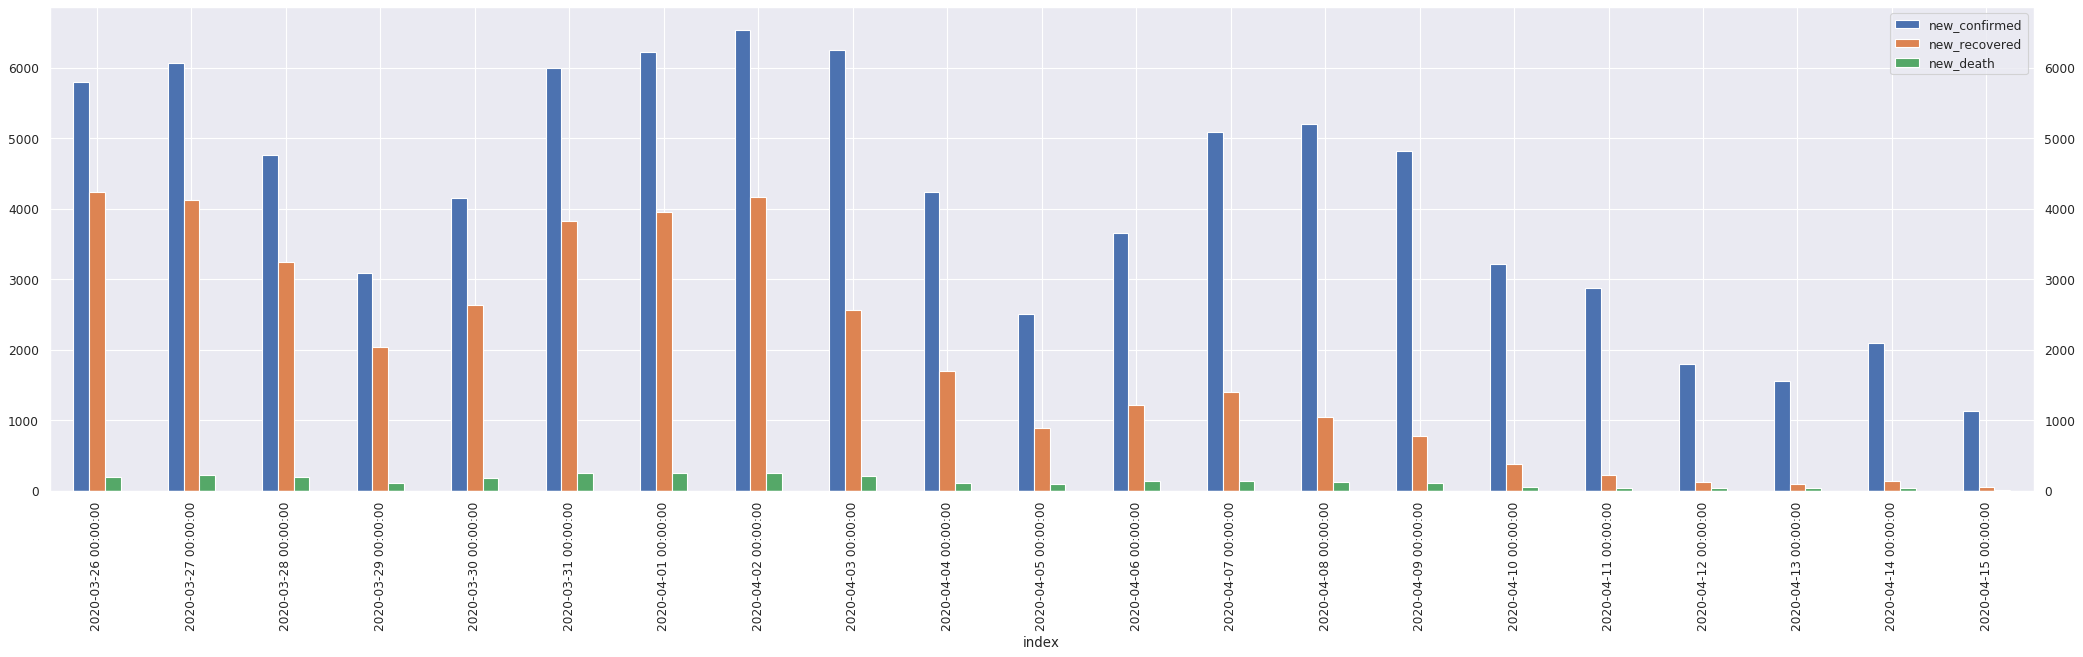

In [26]:
cbr_germany.plot_daily_stats()

sigmoid+linear 2020-05-24 00:00:00 [95083.27112594     0.18962482   -11.449548   11389.19968072] 0.02024599846021724 2159.674929213482


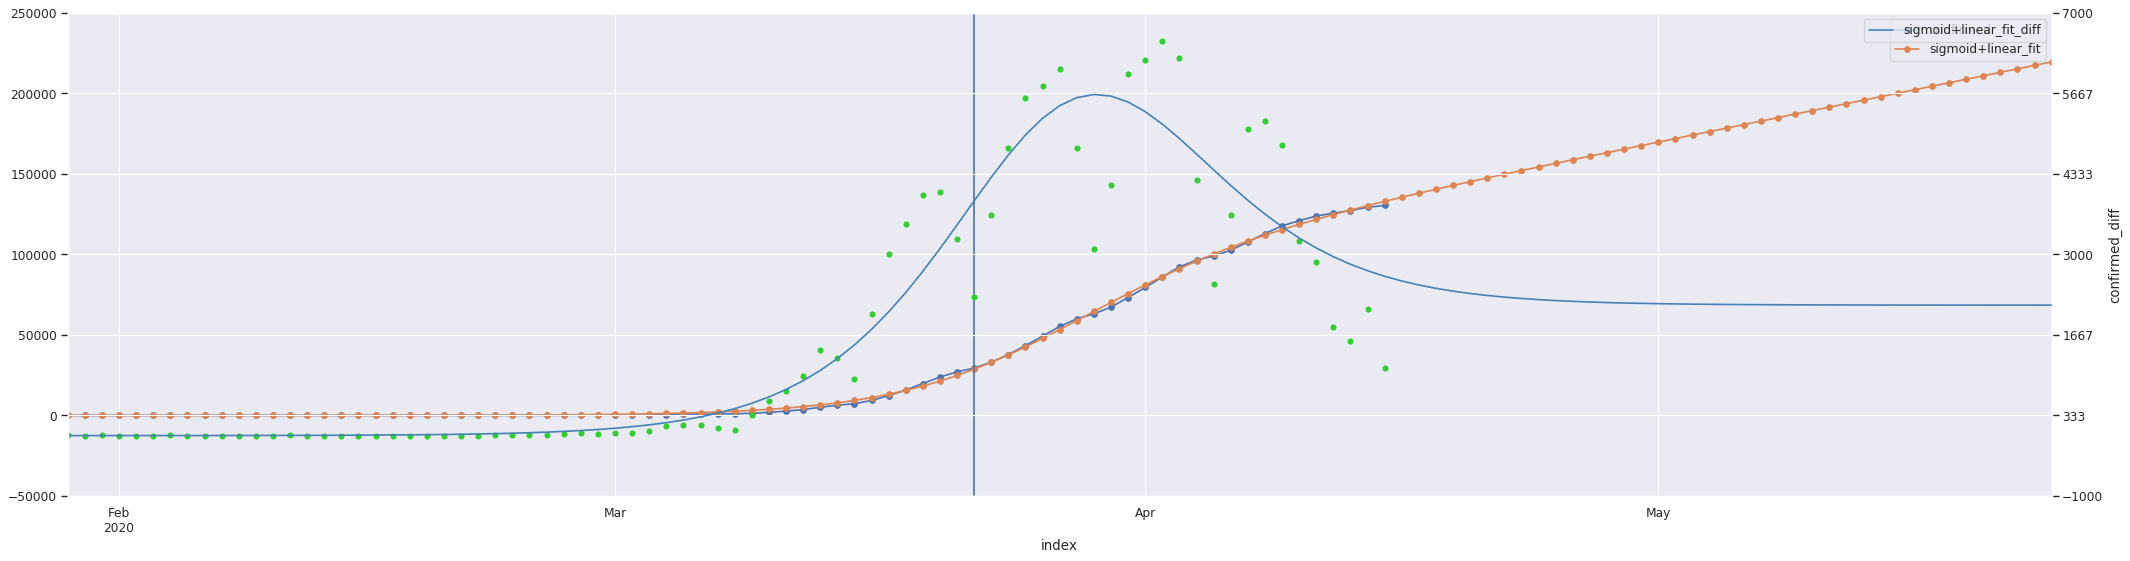

In [27]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany.df, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [28]:
ldf[[label + '_fit_diff']].apply(['max'])

,sigmoid+linear_fit_diff
max,5647.855949


In [29]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

1122.0

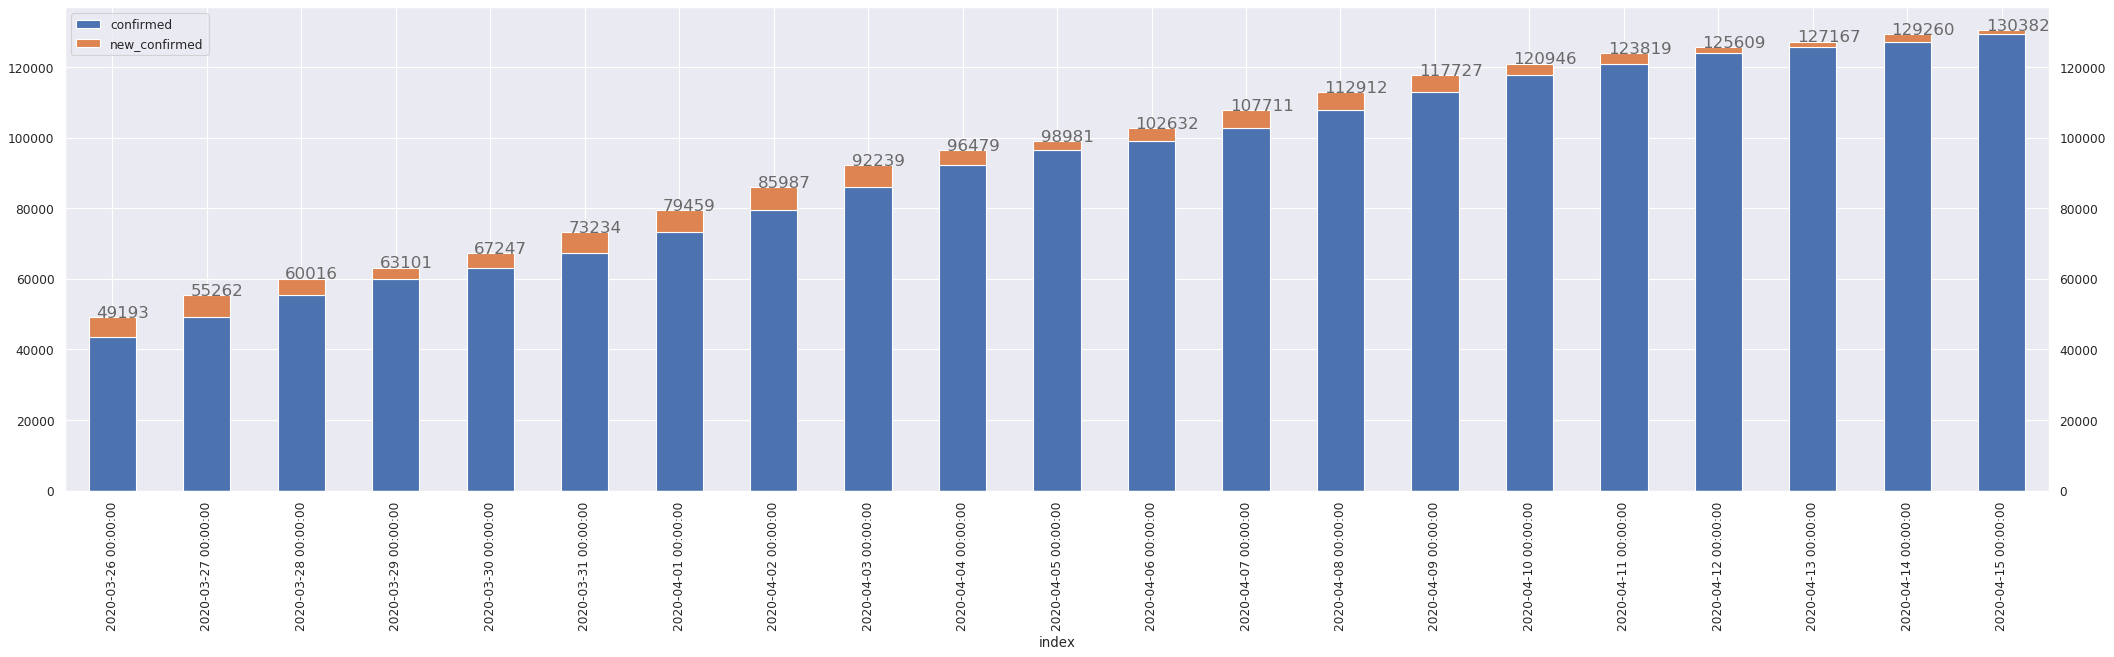

In [30]:
cbr_germany.plot_daily_stacked()

In [31]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [32]:
cbr_germany2 = covid19.CasesByRegion('Germany', df=create_rki_df(df_, time_anchor_column_name='Referenzdatum'))
cbr_germany2.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-11,126541,76934,3507,1783,0,19
2020-04-12,127634,76934,3524,1093,0,17
2020-04-13,128503,76933,3543,869,-1,19
2020-04-14,129646,76933,3562,1143,0,19
2020-04-15,130382,76932,3567,736,-1,5


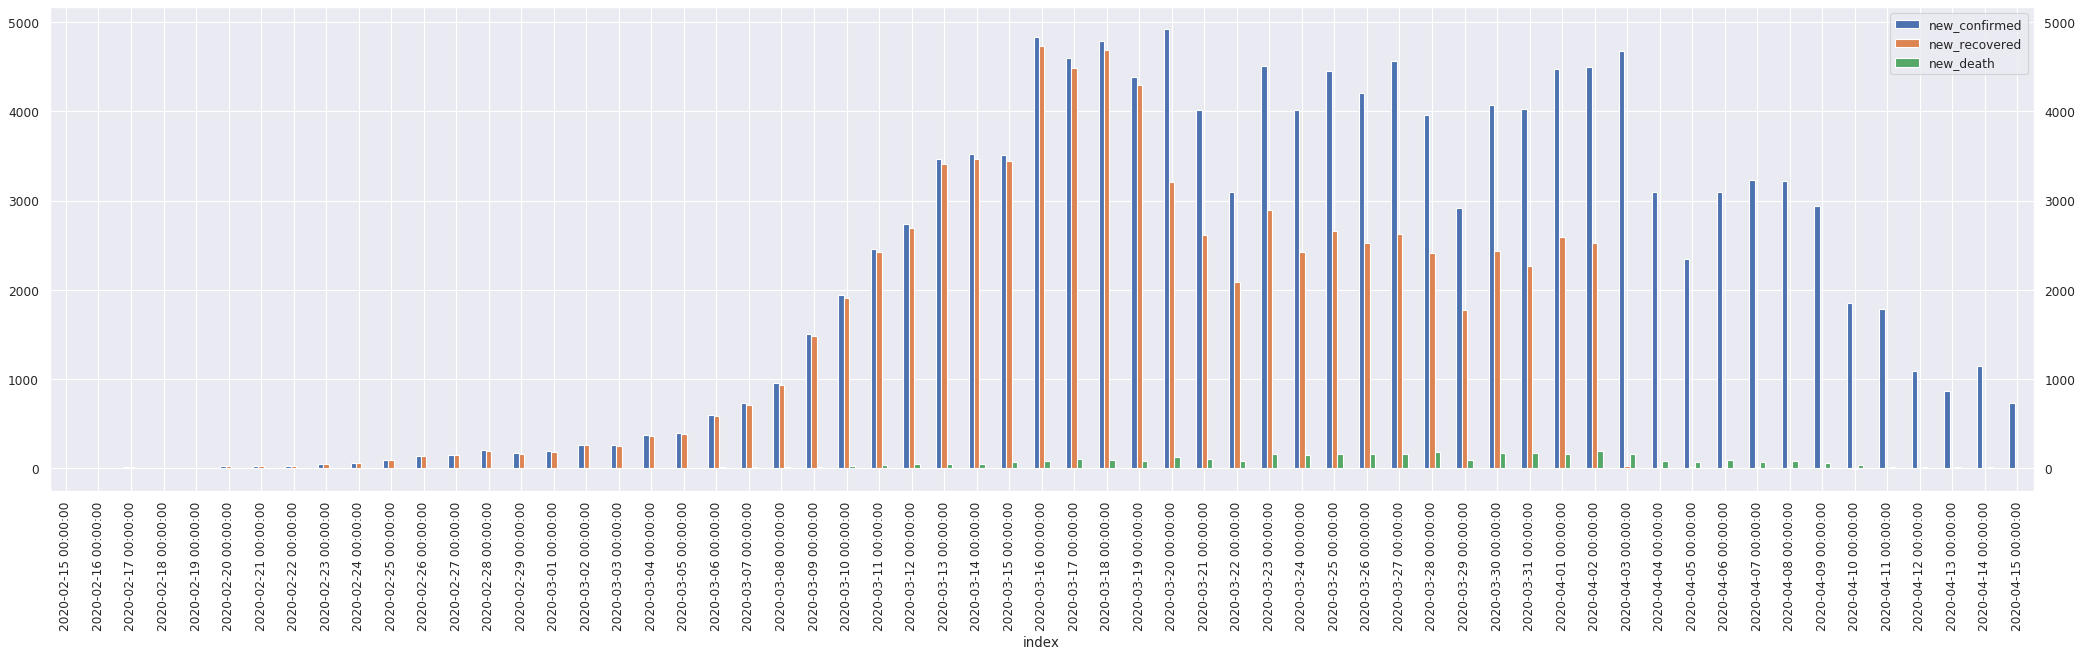

In [33]:
cbr_germany2.plot_daily_stats(days=60)

/home/local/cs/local/install/anaconda3-5.3.1-Linux-x86_64/envs/py36ds/lib/python3.6/site-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


exp 2020-05-24 00:00:00 [1348.76674857    0.04472125] 0.045736320931728525 0.0


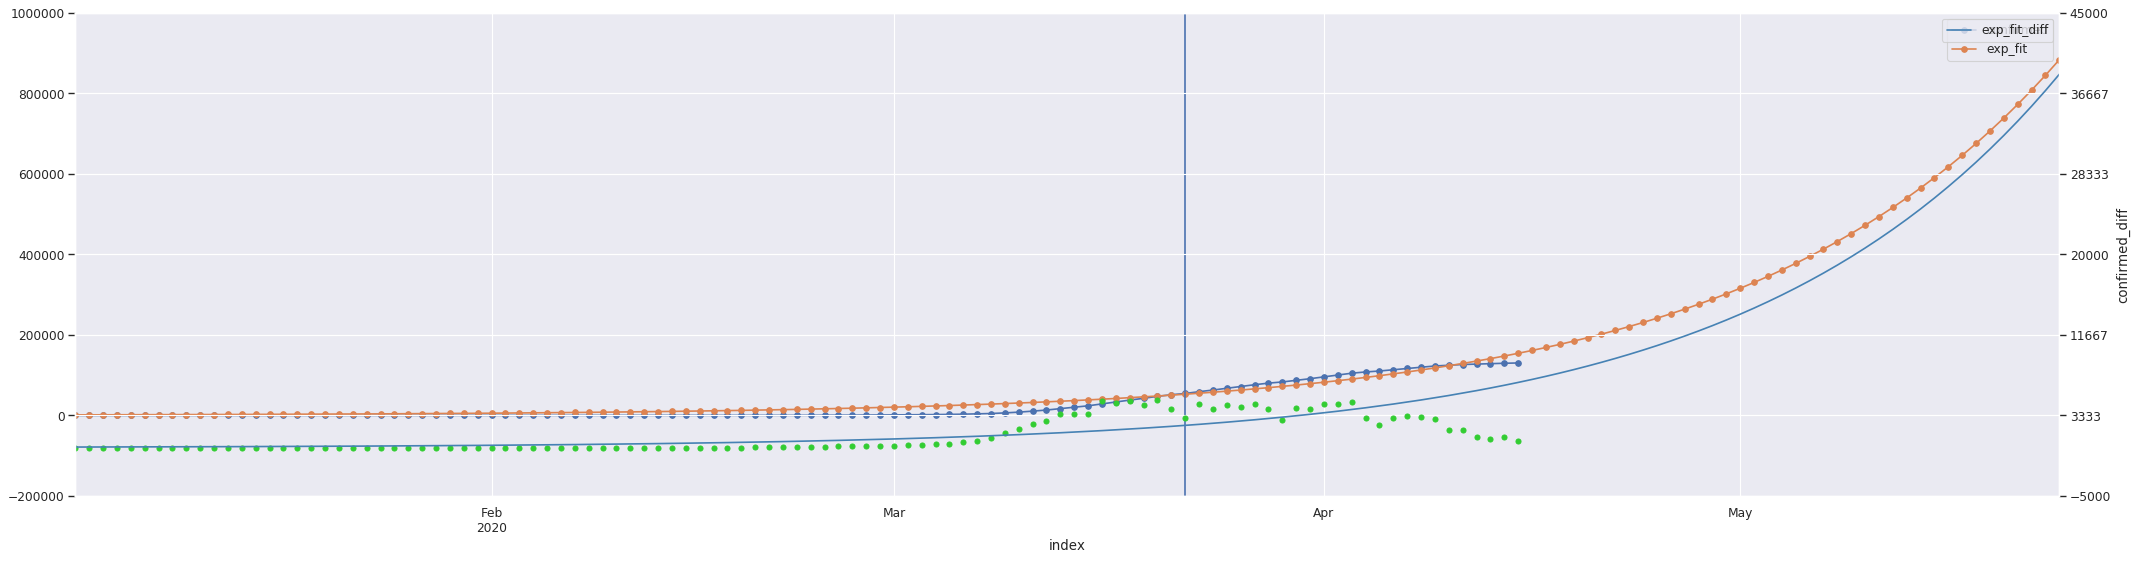

In [34]:
country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_germany2.df, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [35]:
ldf[[label + '_fit_diff']].apply(['max'])

,exp_fit_diff
max,38636.144231


In [36]:
lds = ldf['confirmed']
idx = lds.index.get_loc(lds.last_valid_index())
lds.iloc[idx] - lds.iloc[idx-1]

736.0

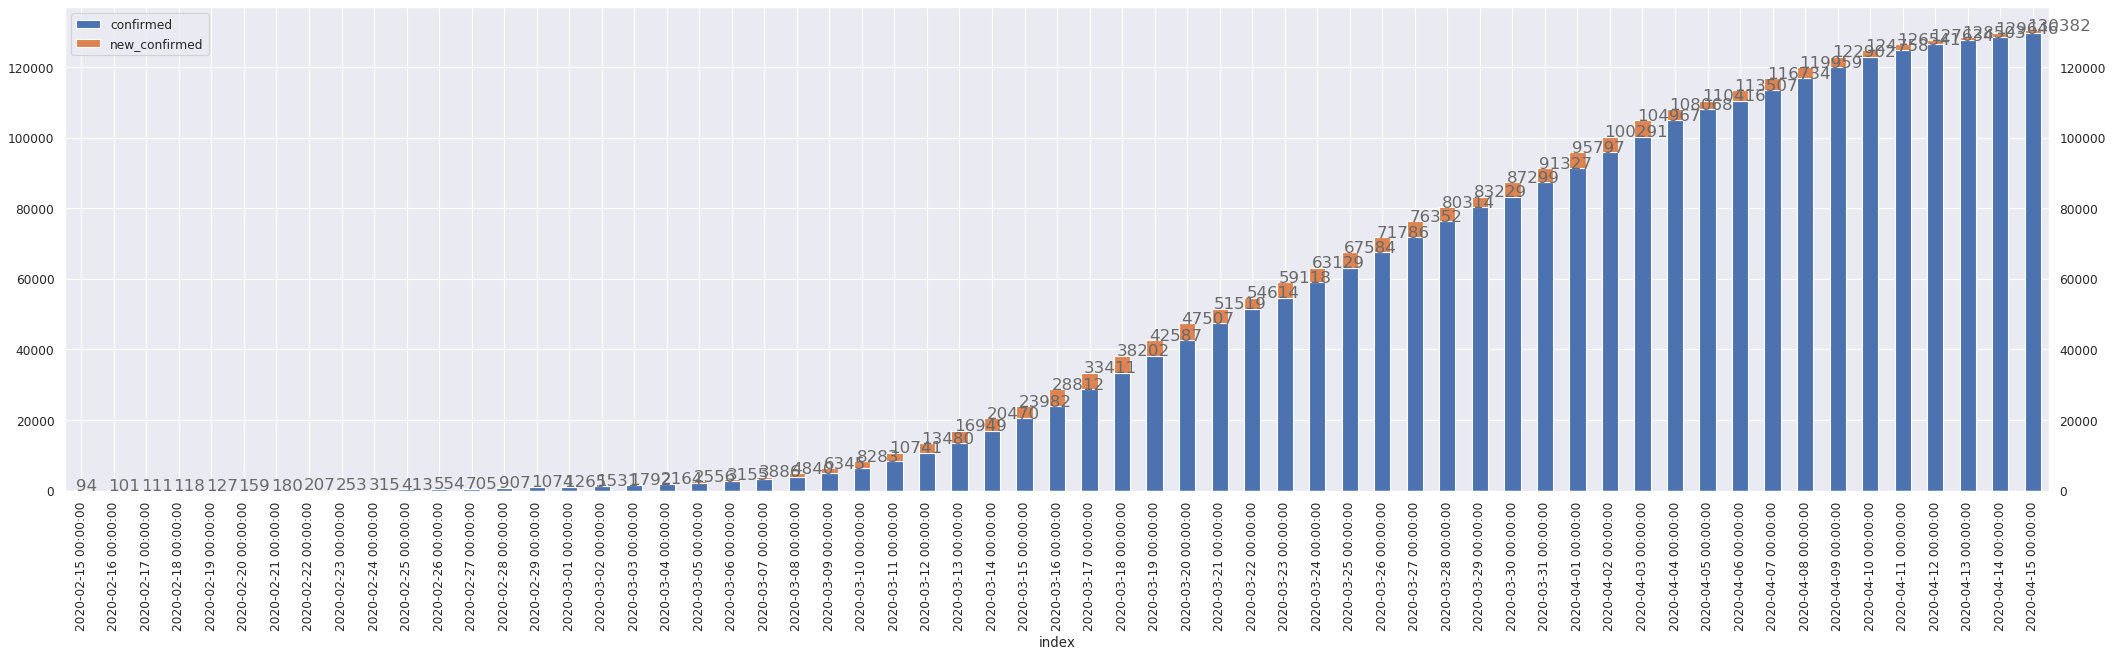

In [37]:
cbr_germany2.plot_daily_stacked(days=60)

In [31]:
# --------------------------------------------------------------------------------------------------------------------------------



# --------------------------------------------------------------------------------------------------------------------------------

In [56]:
cbr_bavaria = covid19.CasesByRegion('Bavaria', df=create_rki_df(df_, state='Bayern'))
cbr_bavaria.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-11,33040,17642,1019,788,62,19
2020-04-12,33453,17674,1026,413,32,7
2020-04-13,33908,17695,1038,455,21,12
2020-04-14,34610,17728,1048,702,33,10
2020-04-15,35125,17748,1049,515,20,1


In [54]:
# cbr_bavaria.plot_daily_stats()

sigmoid 2020-04-25 00:00:00 [37109.95015293     0.18500801   -11.85810369] 0.012125163308840836 0.0


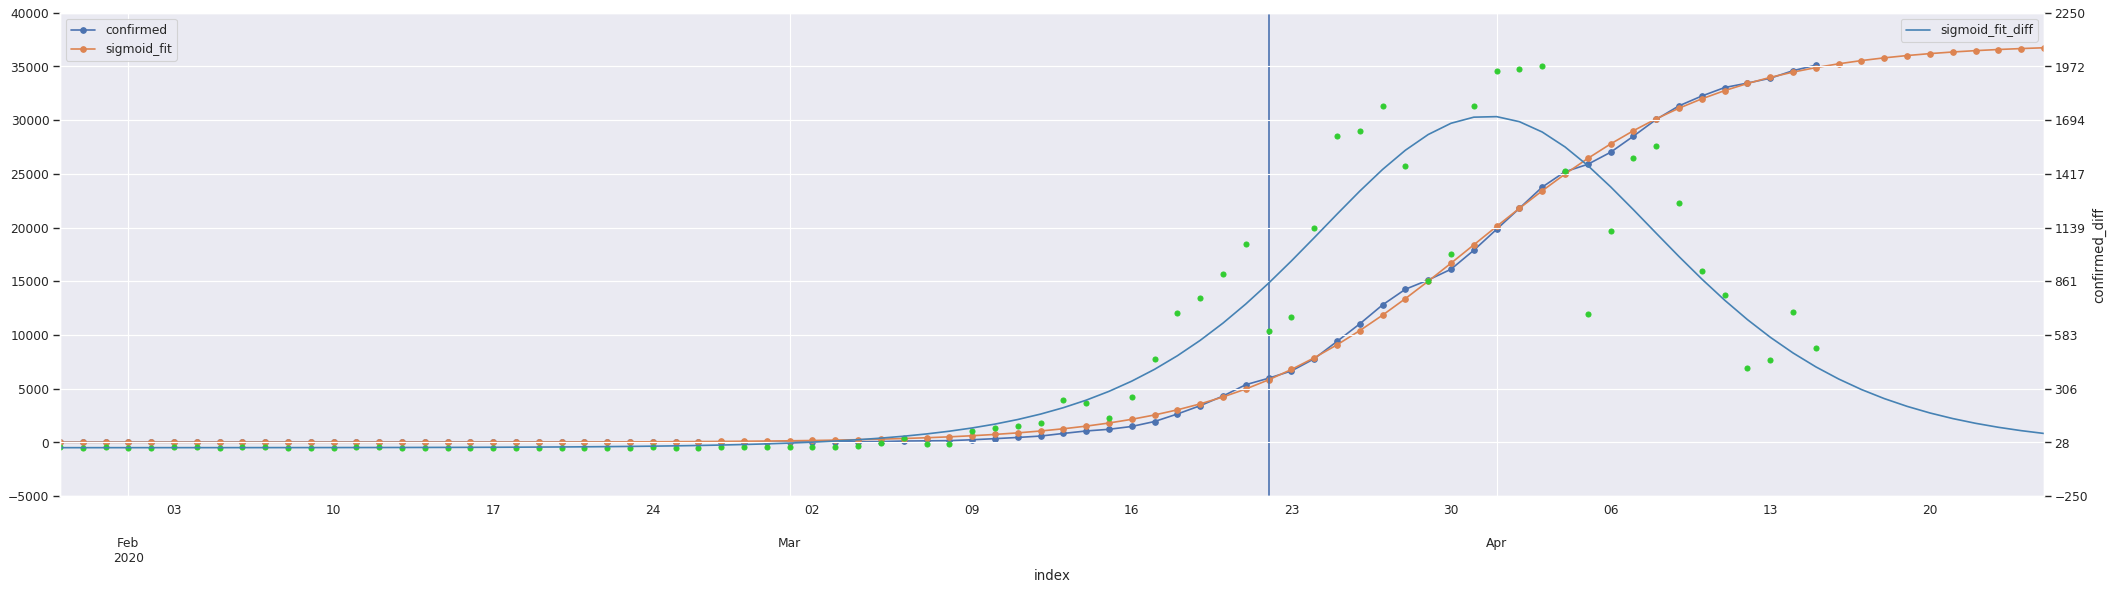

In [57]:
country_name, first_date, init_add, restriction_start_date = 'Bayern', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_bavaria.df, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [58]:
cbr_nrw = covid19.CasesByRegion('NRW', df=create_rki_df(df_, state='Nordrhein-Westfalen'))
cbr_nrw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-11,25180,17846,641,575,62,1
2020-04-12,25559,17883,648,379,37,7
2020-04-13,25848,17911,653,289,28,5
2020-04-14,26271,17960,662,423,49,9
2020-04-15,26371,17967,663,100,7,1


sigmoid+linear 2020-05-24 00:00:00 [15535.13217092     0.18564392    -6.06855343  3002.00583126] 0.022729523893607606 557.3041251140003


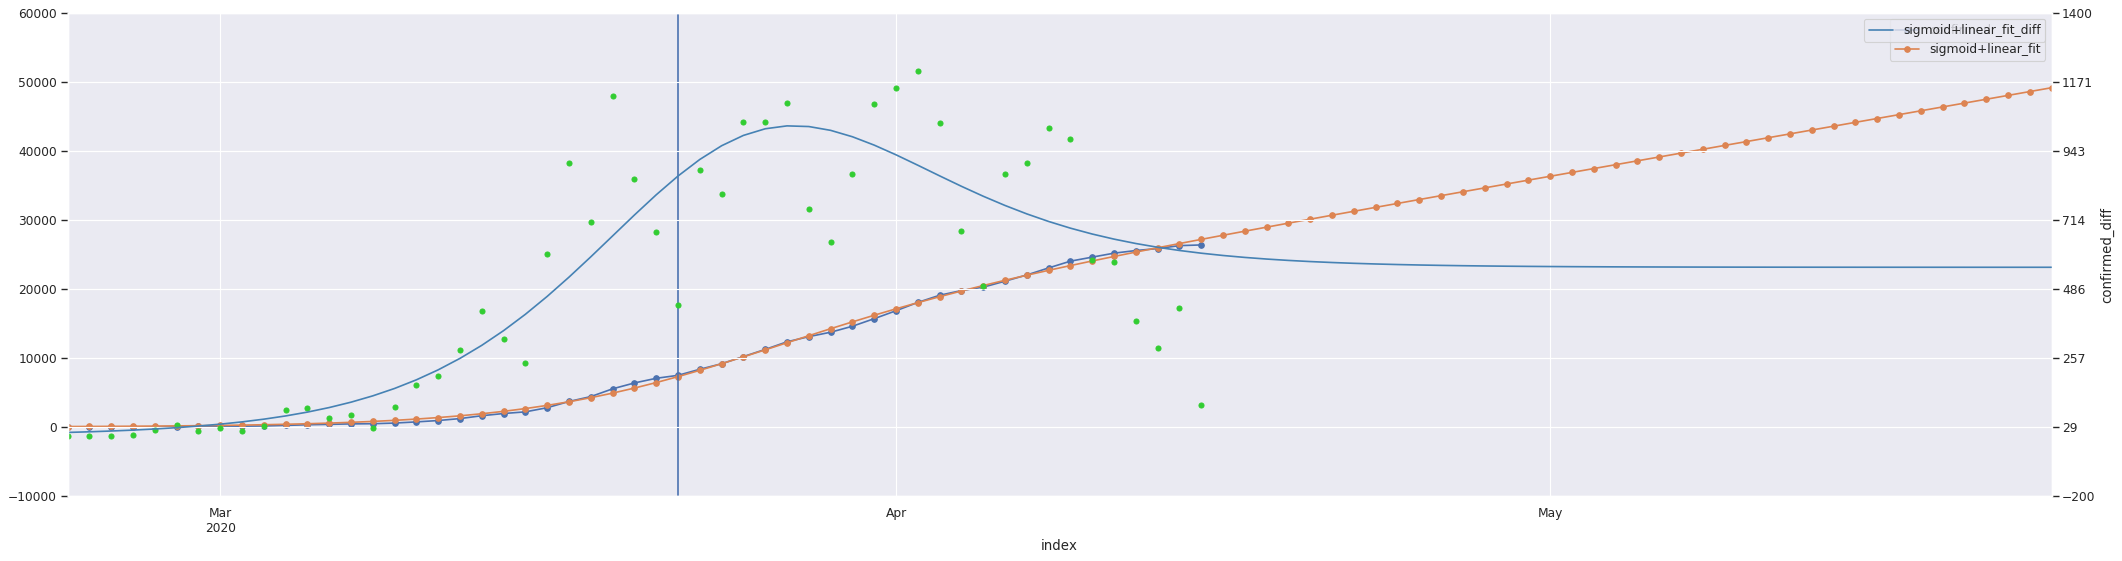

In [59]:
country_name, first_date, init_add, restriction_start_date = 'Nordrhein-Westfalen', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_nrw.df, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [60]:
cbr_bw = covid19.CasesByRegion('BW', df=create_rki_df(df_, state='Baden-Württemberg'))
cbr_bw.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-11,25007,13829,780,726,30,3
2020-04-12,25375,13840,788,368,11,8
2020-04-13,25639,13850,795,264,10,7
2020-04-14,25869,13857,802,230,7,7
2020-04-15,25874,13857,802,5,0,0


sigmoid+linear 2020-05-24 00:00:00 [20711.72998849     0.19125094   -11.18731029  1777.00873623] 0.01723110884430512 339.85459726823194


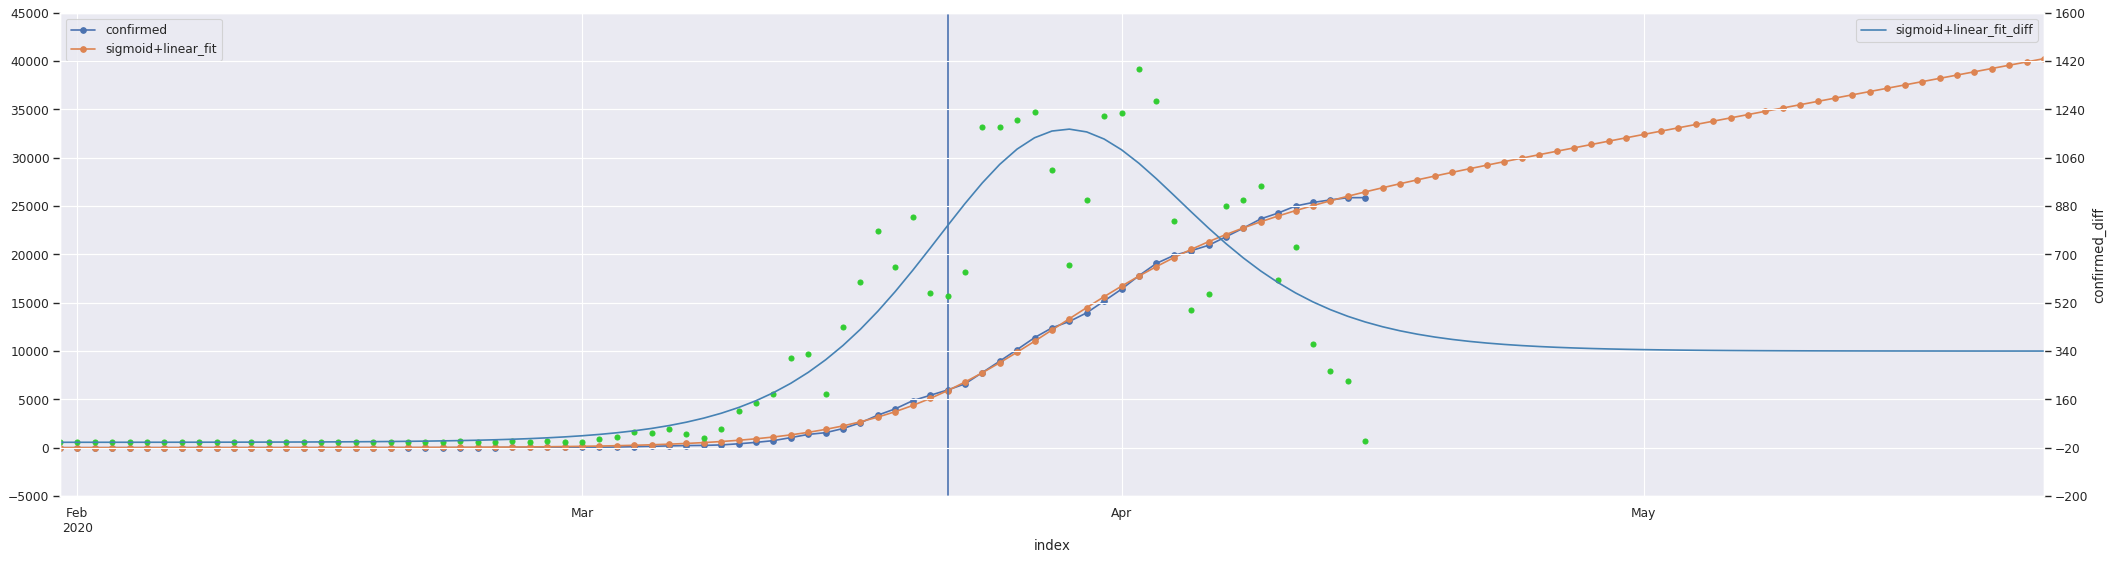

In [61]:
country_name, first_date, init_add, restriction_start_date = 'Baden-Württemberg', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_bw.df, first_date=first_date, init_add=init_add)
if len(lpopt) == 4:
    steady_state_rate = lpopt[1] * lpopt[3]
else:
    steady_state_rate = 0.0
print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
ax = plt.subplot(1,1,1)
ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
ax.axvline(restriction_start_date);

ax2 = ax.twinx()
ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
lbl = 'confirmed' + '_diff'
ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


l = len(ax.get_yticks())
a1 = ax.get_yticks()[0]
e1 = ax.get_yticks()[-1]
a2 = ax2.get_yticks()[0]
e2 = ax2.get_yticks()[-1]
ax.set_yticks(np.linspace(a1, e1, l));
ax2.set_yticks(np.linspace(a2, e2, l));

In [45]:
# df_['Landkreis'].unique()

In [62]:
cbr_traunstein = covid19.CasesByRegion('LK Traunstein', df=create_rki_df(df_, county='LK Traunstein'))
cbr_traunstein.tail()

,confirmed,recovered,death,new_confirmed,new_recovered,new_death
index,,,,,,
2020-04-11,746,435,26,17,0,2
2020-04-12,763,435,26,17,0,0
2020-04-13,768,435,26,5,0,0
2020-04-14,793,436,26,25,1,0
2020-04-15,797,436,26,4,0,0


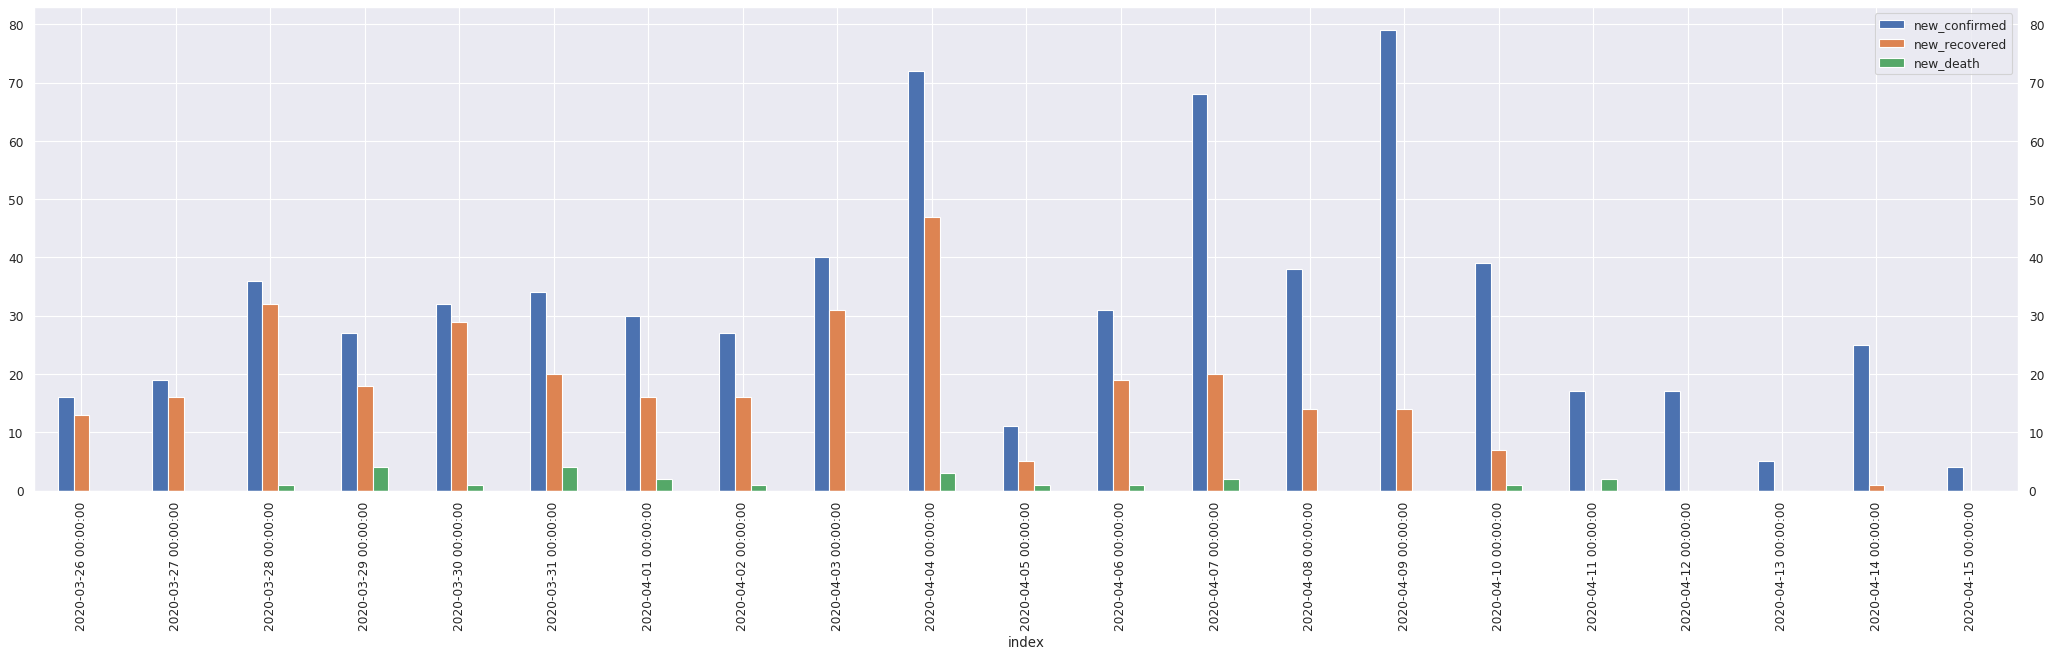

In [63]:
cbr_traunstein.plot_daily_stats()

In [50]:
# country_name, first_date, init_add, restriction_start_date = 'Germany', pd.to_datetime('2020-03-09'), 0, datetime.datetime(2020, 3, 22)
# ldf, lpopt, lpcov, lsqdiff, lgrowthRate, idx, label = covid19.prepare_country_prediction(country_name, in_df=cbr_traunstein.df, first_date=first_date, init_add=init_add)
# if len(lpopt) == 4:
#     steady_state_rate = lpopt[1] * lpopt[3]
# else:
#     steady_state_rate = 0.0
# print(label, ldf.index[-1], lpopt, lgrowthRate, steady_state_rate)
# fig = plt.figure(figsize=(32,8), dpi=80, facecolor='w', edgecolor='k')
# ax = plt.subplot(1,1,1)
# ldf[['confirmed', label + '_fit']].iloc[1:,:].plot(ax=ax, marker=mpl.path.Path.unit_circle(), markersize=5);
# ax.axvline(restriction_start_date);

# ax2 = ax.twinx()
# ldf[[label + '_fit_diff']].iloc[1:,:].plot(ax=ax2, color=['steelblue']);
# lbl = 'confirmed' + '_diff'
# ldf[[lbl]].iloc[1:,:].reset_index().plot.scatter(ax=ax2, x = 'index', y = lbl, c='limegreen')


# l = len(ax.get_yticks())
# a1 = ax.get_yticks()[0]
# e1 = ax.get_yticks()[-1]
# a2 = ax2.get_yticks()[0]
# e2 = ax2.get_yticks()[-1]
# ax.set_yticks(np.linspace(a1, e1, l));
# ax2.set_yticks(np.linspace(a2, e2, l));

In [51]:
# ldf